# NN implementation - IDS

In [32]:
import ids_utils, ids_metrics

from sklearn import preprocessing

import numpy as np
from minisom import MiniSom
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
pd.set_option('display.max_columns', None)

In [33]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.callbacks import EarlyStopping

In [28]:
def print_som_metrics(metrics):
    print('False alarm rate: {}%'.format(metrics.get_false_alarm_rate()*100))
    print('Detection rate: {}%'.format(metrics.get_detection_rate()*100))
    print("Acc: {}".format(metrics.get_accuracy()))
    print("TN: {}".format(metrics.tn))
    print("TP: {}".format(metrics.tp))
    print("FN: {}".format(metrics.fn))
    print("FP: {}".format(metrics.fp))
    print("Total instances: {}".format(metrics.size))
    print("Correctly classified: {}".format(metrics.hits))
    
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df.as_matrix(result).astype(np.float32), dummies.as_matrix().astype(np.float32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32), df.as_matrix([target]).astype(np.float32)

def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


In [5]:
df = ids_utils.load_ids_df('./data/kddcup.data_10_percent_corrected.csv')
np.shape(df)

(494020, 42)

In [6]:
ids_utils.encode_dummy_variables(df, 'protocol_type')
ids_utils.encode_dummy_variables(df, 'service')
ids_utils.encode_dummy_variables(df, 'flag')
# Convert attack types in order to have binary classification
df.loc[df.outcome != 'normal.', 'outcome'] = 'malicious.'
df.loc[df.outcome == 'normal.', 'outcome'] = 'normal.'
outcomes = encode_text_index(df, 'outcome')
num_classes = len(outcomes)
numeric_df = df.select_dtypes(include=['float64', 'int64', 'uint8'])
for col in numeric_df.columns:
    if col is not 'outcome':
        ids_utils.encode_numeric_zscore(numeric_df, col)

In [7]:
numeric_df.head()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,protocol_type-icmp,protocol_type-tcp,protocol_type-udp,service-IRC,service-X11,service-Z39_50,service-auth,service-bgp,service-courier,service-csnet_ns,service-ctf,service-daytime,service-discard,service-domain,service-domain_u,service-echo,service-eco_i,service-ecr_i,service-efs,service-exec,service-finger,service-ftp,service-ftp_data,service-gopher,service-hostnames,service-http,service-http_443,service-imap4,service-iso_tsap,service-klogin,service-kshell,service-ldap,service-link,service-login,service-mtp,service-name,service-netbios_dgm,service-netbios_ns,service-netbios_ssn,service-netstat,service-nnsp,service-nntp,service-ntp_u,service-other,service-pm_dump,service-pop_2,service-pop_3,service-printer,service-private,service-red_i,service-remote_job,service-rje,service-shell,service-smtp,service-sql_net,service-ssh,service-sunrpc,service-supdup,service-systat,service-telnet,service-tftp_u,service-tim_i,service-time,service-urh_i,service-urp_i,service-uucp,service-uucp_path,service-vmnet,service-whois,flag-OTH,flag-REJ,flag-RSTO,flag-RSTOS0,flag-RSTR,flag-S0,flag-S1,flag-S2,flag-S3,flag-SF,flag-SH
0,-0.067792,-0.002820,-0.011578,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,2.396994,-0.005679,-0.010552,-0.004676,-0.00564,-0.011232,-0.009919,-0.027632,NaN,NaN,-0.037263,-1.521420,-1.156642,-0.46409,-0.463521,-0.24796,-0.248631,0.536988,-0.255243,-0.203633,-3.297125,-1.600016,0.599396,-0.282867,-1.146738,-0.158629,-0.464418,-0.463202,-0.25204,-0.249464,1,-1.160948,1.264605,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,-0.014014,-0.014441,-0.015325,-0.015325,-0.109592,-0.015059,-0.057748,-1.150428,-0.014441,-0.014158,-0.036852,-0.040223,-0.098227,-0.015391,-0.014511,2.585342,-0.014158,-0.015391,-0.015259,-0.01465,-0.014086,-0.0143,-0.014371,-0.014511,-0.014719,-0.014086,-0.014158,-0.014371,-0.014719,-0.013869,-0.01458,-0.014787,-0.027745,-0.12193,-0.001423,-0.0143,-0.020225,-0.014856,-0.537997,-0.001423,-0.015587,-0.014991,-0.015059,-0.141692,-0.014924,-0.01458,-0.014719,-0.01458,-0.015259,-0.032241,-0.001423,-0.003764,-0.01783,-0.005324,-0.033018,-0.01465,-0.01465,-0.01465,-0.014924,-0.004024,-0.239855,-0.034255,-0.004719,-0.042793,-0.462352,-0.010742,-0.00697,-0.004499,0.552643,-0.014719
1,-0.067792,-0.002824,0.014179,-0.006673,-0.04772,-0.002571,-0.044136,-0.009782,2.396994,-0.005679,-0.010552,-0.004676,-0.00564,-0.011232,-0.009919,-0.027632,NaN,NaN,-0.037263,-1.521420,-1.156642,-0.46409,-0.463521,-0.24796,-0.248631,0.536988,-0.255243,-0.203633,-3.142672,-1.505712,0.599396,-0.282867,-1.188292,-0.158629,-0.464418,-0.463202,-0.25204,-0.249464,1,-1.160948,1.264605,-0.207295,-0.00933,-0.004719,-0.013648,-0.025776,-0.01465,-0.014787,-0.015972,-0.014014,-0.014441,-0.015325,-0.015325,-0.109592,-0.015059,-0.057748,-1.150428,-0.014441,-0.014158,-0.036852,-0.040223,-0.098227,-0.015391,-0.014511,2.585342,-0.014158,-0.015391,-0.015259,-0.01465,-0.014086,-0.0143,-0.014371,-0.014511,-0.014719,-0.014086,-0.014158,-0.014371,-0.014719,-0.013869,-0.01458,-0.014787,-0.027745,-0.12193,-0.001423,-0.0143,-0.020225,-0.014856,-0.537997,-0.001423,-0.015587,-0.014991,-0.015059,-0.141692,-0.014924,-0.01458,-0.014719,-0.01458,-0.015259,-0.032241,-0.001423,-0.003764,-0.01783,-0.005324,-0.033018,-0.01465,-0.01465,-0.01465,-0.014924,-0.004024,-0.239855,-0.034255,-0.004719,-0.042793,-0.462352,-0.010742,-0.00697,-0.004499,0.552643,-0.014719
2,-0.

In [8]:
numeric_df.describe()

,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,count,srv_count,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,same_srv_rate,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,outcome,protocol_type-icmp,protocol_type-tcp,protocol_type-udp,service-IRC,service-X11,service-Z39_50,service-auth,service-bgp,service-courier,service-csnet_ns,service-ctf,service-daytime,service-discard,service-domain,service-domain_u,service-echo,service-eco_i,service-ecr_i,service-efs,service-exec,service-finger,service-ftp,service-ftp_data,service-gopher,service-hostnames,service-http,service-http_443,service-imap4,service-iso_tsap,service-klogin,service-kshell,service-ldap,service-link,service-login,service-mtp,service-name,service-netbios_dgm,service-netbios_ns,service-netbios_ssn,service-netstat,service-nnsp,service-nntp,service-ntp_u,service-other,service-pm_dump,service-pop_2,service-pop_3,service-printer,service-private,service-red_i,service-remote_job,service-rje,service-shell,service-smtp,service-sql_net,service-ssh,service-sunrpc,service-supdup,service-systat,service-telnet,service-tftp_u,service-tim_i,service-time,service-urh_i,service-urp_i,service-uucp,service-uucp_path,service-vmnet,service-whois,flag-OTH,flag-REJ,flag-RSTO,flag-RSTOS0,flag-RSTR,flag-S0,flag-S1,flag-S2,flag-S3,flag-SF,flag-SH
count,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,0.0,0.0,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,494020.000000,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05,4.940200e+05
mean,3.426001e-17,7.694838e-19,1.150630e-19,1.280076e-18,-1.236927e-18,2.062145e-18,-1.275761e-17,-1.941688e-18,-1.288706e-16,-4.167438e-18,2.502620e-18,1.229736e-18,3.430315e-18,3.685611e-18,3.308061e-18,-1.101728e-17,NaN,NaN,-7.133905e-18,3.313814e-17,-3.405865e-17,1.988288e-16,1.449794e-16,1.203559e-16,7.962359e-17,-1.933058e-16,-8.019890e-17,-7.364031e-17,3.313814e-17,5.338923e-17,9.826379e-17,-9.423659e-17,3.111303e-16,7.456082e-17,1.831803e-16,2.720089e-16,1.472806e-16,1.426781e-16,0.196909,2.494566e-16,-1.583267e-16,-1.088496e-16,1.308842e-18,3.092318e-19,-1.740328e-18,1.277199e-17,-3.221764e-18,-1.438287e-18,6.616122e-19,1.898539e-18,7.191437e-19,-8.284535e-18,-4.890177e-18,-9.826379e-17,-8.529044e-18,1.731698e-17,-2.071134e-16,-9.492697e-1

In [9]:
pd.DataFrame(numeric_df['outcome']).apply(pd.value_counts)

,outcome
0,396743
1,97277


In [56]:
np.shape(df)

(494020, 119)

In [10]:
x,y = to_xy(df, 'outcome')

In [11]:
batch_size = 500


x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)

# Create neural net
model = Sequential()
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(15, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(10, input_dim=x.shape[1], kernel_initializer='normal', activation='relu'))
model.add(Dense(1, kernel_initializer='normal'))
model.add(Dense(y.shape[1],activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
history = model.fit(x_train,y_train,validation_data=(x_test,y_test),batch_size=batch_size,
          callbacks=[monitor],verbose=1,epochs=100)

Train on 370515 samples, validate on 123505 samples
Epoch 1/100
370515/370515 [==============================] - 12s 32us/step - loss: 0.0897 - acc: 0.9770 - val_loss: 0.0339 - val_acc: 0.9914
Epoch 2/100
370515/370515 [==============================] - 10s 27us/step - loss: 0.0375 - acc: 0.9910 - val_loss: 0.0267 - val_acc: 0.9932
Epoch 3/100
370515/370515 [==============================] - 11s 30us/step - loss: 0.0305 - acc: 0.9923 - val_loss: 0.0404 - val_acc: 0.9904
Epoch 4/100
370515/370515 [==============================] - 10s 28us/step - loss: 0.0194 - acc: 0.9941 - val_loss: 0.0169 - val_acc: 0.9955
Epoch 5/100
370515/370515 [==============================] - 10s 28us/step - loss: 0.0140 - acc: 0.9963 - val_loss: 0.0150 - val_acc: 0.9963
Epoch 6/100
370515/370515 [==============================] - 10s 27us/step - loss: 0.0130 - acc: 0.9963 - val_loss: 0.0132 - val_acc: 0.9963
Epoch 7/100
370515/370515 [==============================] - 10s 27us/step - loss: 0.0123 - acc: 0.996

# Plots

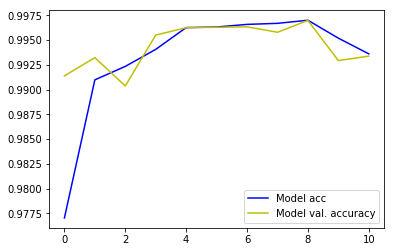

In [54]:
train_output = history

acc = plt.plot(train_output.epoch, train_output.history['acc'], color='b', label='Accuracy')
val_acc = plt.plot(train_output.epoch, train_output.history['val_acc'], color='y', label='Validation acc.')
plt.legend(['Model acc', 'Model val. accuracy'])
plt.savefig('./nn-model-acc.png')
plt.show()

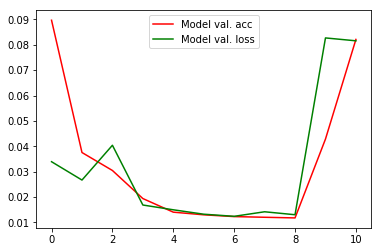

In [55]:
plt.close()
loss = plt.plot(train_output.epoch, train_output.history['loss'], color='r', label='Loss')
val_loss= plt.plot(train_output.epoch, train_output.history['val_loss'], color='g', label='Validation loss')
plt.legend(['Model val. acc', 'Model val. loss'])
plt.savefig('./nn-model-loss.png')
plt.show()

# Validation

In [51]:
pred = model.predict(x_test)
pred = np.argmax(pred,axis=1)
y_eval = np.argmax(y_test,axis=1)
score = metrics.accuracy_score(y_eval, pred)
print("Validation score: {}".format(score))


Validation score: 0.9933848832031091


In [52]:
#obtain the accuracy 
ac=metrics.accuracy_score(pred,y_eval)
#obtain the confusion matrix
cm=metrics.confusion_matrix(y_eval, pred)

tn, fp, fn, tp = cm.ravel()
ids_metric = ids_metrics.IdsMetric(len(y_eval), tp+tn, tp, tn, fp, fn)

In [53]:
print_som_metrics(ids_metric)

False alarm rate: 0.4858966440189417%
Detection rate: 99.51410335598105%
Acc: 0.9933848832031091
TN: 98521
TP: 24167
FN: 118
FP: 699
Total instances: 123505
Correctly classified: 122688
